In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as st

from sklearn.linear_model import LinearRegression as linreg

## Exercise 1: Simple Linear Equation Example

Consider a simple market equilibrium model where the demand and supply function are respectively given by

$$\text{D}\colon\quad p=a-bq$$

$$\text{S}\colon\quad p=c+dq$$

where $p$ is the price, $q$ is the quantity and $a,b,c,d$ are parameters.


In [2]:
def D(q, a, b):
    """
    Linear quantity demand function as a function of quantity.

    Arguments:
    q - quanity input
    a - intercept
    b - slope

    Returns:
    p - price output
    """
    p = a-b*q

    return p

def invD(p, a, b):
    """
    Inverse linear quantity demand function as a function of price.

    Arguments:
    p - price input
    a - intercept
    b - slope

    Returns:
    q - quantity output
    """

    q = (a-p)/b

    return q

def S(q, c, d):
    """
    Linear quantity supply function as a function of quantity.

    Arguments:
    q - quantity input
    c - intercept
    d - slope

    Returns:
    p - price output
    """
    p = c+d*q

    return p

def invS(p, c, d):
    """
    Inverse linear quantity supply function as a function of price.

    Arguments:
    p - price input
    c - intercept
    d - slope

    Returns:
    q - quantity output
    """
    q = (p-c)/d

    return q

### 1. Show that market equilibirum is characterized by the relationship

$$bq+dq-(a-c)=0$$

First off, define the excess supply function:

$$\text{Z}(q)\equiv\text{S}(q)-\text{D}(q)=c+dq-a-bq$$

The market equilibrium is characterized by zero excess quantity:

$$\text{Z}(q)=0\iff bq+dq-(a-c)=0$$

### 2. Analytically compute the equilibrium allocation and corresponding price, $(q^*,p^*)$.

We may derive the optimal market quantity using $\text{Z}(q)=0$:

$$\text{Z}(q)=0\iff q^*=\frac{a-c}{b+d}$$

Hence, the optimal price $p^*$ is then given by:

$$p^*\colon\quad D(p^*)=S(p^*)\iff a-bq^*=c+dq^*$$

The optimum allocation of the economy is the pair $(q^*,p^*)$.

### 3. Next, transform the system of equations $\text{D}$ and $\text{S}$ into a standard linear equation system of the form $\mathbf A\mathbf x=\mathbf y$ for coefficient matrix $\mathbf A$, variable vector $\mathbf x=[p,q]^\intercal$ and data vector $\mathbf y$. Analytically solve this system of equations by an LU decomposition applying the steps from the slides of the lecture.

Define coefficient matrix $\mathbf A$ as

$$\mathbf A=\begin{bmatrix}a&-b\\c&d\end{bmatrix}$$

Define the variable vector $\mathbf x$ and the data vector $y$ as

$$\mathbf x=[1,q]^\intercal$$

$$y=[p, p]^\intercal$$

Hence, the economy is defined as

$$\mathbf A\mathbf x=y\iff \begin{bmatrix}a&-b\\c&d\end{bmatrix}\begin{bmatrix}1\\q\end{bmatrix}=\begin{bmatrix}p\\p\end{bmatrix}$$

Let $\mathbf I$ be identity matrix of shape $(2,2)$. Using Gaussian elimination algorithm we nullify the entries below the main diagonal of matrix $\mathbf A$ and let $\mathbf I_{22}=-\mathbf A_{22}$$:

$$\mathbf A=\begin{bmatrix}a&-b\\c&d\end{bmatrix}\stackrel{\mathbf A_{2}-\mathbf A_{1}\frac{\mathbf A_{21}}{\mathbf A_{11}}}{\to}\begin{bmatrix}a&-b\\0&\tilde{d}\end{bmatrix}=\mathbf A^1$$

$$\mathbf I=\begin{bmatrix}1&0\\0&1\end{bmatrix}\stackrel{\mathbf I_{22}=\frac{\mathbf A_{21}}{\mathbf A_{11}}}{\to}\begin{bmatrix}1&0\\\frac{c}{a}&1\end{bmatrix}=\mathbf I^1$$

where $\tilde{d}=d+b\frac{c}{a}$. Hence, $\mathbf A^1\equiv\mathbf U$ is the upper triangular matrix and $\mathbf I^1\equiv\mathbf L$ is the lower triangular matrix satisfying

$$\mathbf L\mathbf U=\mathbf A$$

Using forward substitution it may be shown that $\mathbf h$ in the equation

$$\mathbf L\mathbf h=\mathbf y$$

equals $\mathbf h=\biggr[p, (1-\frac{c}{a})p\biggr]^\intercal$

Using backward substitution it may be shown that $\mathbf x$ in the equation

$$\mathbf U\mathbf x=\mathbf h$$

equals $\mathbf x=\biggr[1,\frac{a-c}{d+b}\biggr]^\intercal$. While solving the equation above we find that $p^*=\frac{ad+bc}{d+b}$.



### 4. Now parametrize the model with $a=3,b=0.5,c=d=1$. Compute $(q^*,p^*)$.

We now have the closed form of the optimal allocation $(q^*,p^*)$:

$$(q^*,p^*)=\biggr(\frac{a-c}{d+b},\frac{ad+bc}{d+b}\biggr)=\biggr(\frac{4}{3},\frac{7}{3}\biggr)$$

### 5. Implement a Gauss-Seidel fixed-point iteration for solving the system of equations. Initialize the iteration with $(q,p)=(0.1,0.1). For which order of the equation system does the system converge? Illustrate convergence and non-convergence graphically.

In [3]:
def gaussSeidel(p0, q0, a, b, c, d, order, gammas = [1], numIter = 1000, tol = 1/10e5):
    """
    Gauss-Seidel fixed-point iteration algorithm for solving the system of equations.

    Arguments:
    p0 - initial price input
    q0 - initial quantity input
    a - demand function intercept
    b - demand function slope
    c - supply function intercept
    d - supply function slope
    order - order of solving the system. Takes on only 'direct' and 'indirect' values
    gamma - vector of dampening factors. Default is [1] (no dampening)
    numIter - number of iterations. Default is 1000
    tol - convergence tolerance. Default is 1/10e5

    Returns:
    c, z where
        c - convergence binary True/False
        z - quantity-price output vector of form (p*, q*)
    """
    history = pd.DataFrame(np.array([[0, p0, q0]]), columns=['iteration', 'price', 'quantity'])
    historyGamma = pd.DataFrame(np.array([[0, gammas[0], p0, q0]]), columns=['iteration', 'lambda', 'price', 'quantity'])

    for gamma in gammas:
        c = False
        p1 = p0
        q1 = q0
        Iter = 0

        history = history.append({
                'iteration': Iter,
                'price': p1,
                'quantity': q1},
                ignore_index=True)
        historyGamma = historyGamma.append({
                'iteration': Iter,
                'lambda': gamma,
                'price': p1,
                'quantity': q1},
                ignore_index=True)

        while Iter < numIter:
            Iter += 1

            if order == 'direct':
                p2 = D(q1, a, b)
                q2 = invS(p1, c, d)
            elif order == 'indirect':
                q2 = invD(p1, a, b)
                p2 = S(q1, c, d)
            else:
                return "parameter 'order' must be either 'direct' or 'indirect'"

            history = history.append({
                'iteration': Iter,
                'price': p2,
                'quantity': q2},
                ignore_index=True)
            p2 = gamma * p2 + (1 - gamma) * p1
            q2 = gamma * q2 + (1 - gamma) * q1
            historyGamma = historyGamma.append({
                'iteration': Iter,
                'lambda': gamma,
                'price': p2,
                'quantity': q2},
                ignore_index=True)

            currentState = np.array([p2, q2])
            previousState = np.array([p1, q1])
            dist = np.linalg.norm(currentState - previousState)
            stoppingRule = np.linalg.norm(currentState)

            if dist < tol * (1 + stoppingRule):
                c = True
                z = currentState

                break

            p1 = p2
            q1 = q2
            
        
    z = currentState

    return c, Iter, z, history, historyGamma

cD, IterD, zD, historyD, historyGammaD = gaussSeidel(0.1, 0.1, 3, 1/2, 1, 1, 'direct')
print('ORDER: DIRECT | Converged {} at iteration {}. Set (p*, q*) is {}'.format(cD, IterD, zD))

cI, IterI, zI, historyI, historyGammaI = gaussSeidel(0.1, 0.1, 3, 1/2, 1, 1, 'indirect')
print('ORDER: INDIRECT | Converged {} at iteration {}. Set (p*, q*) is {}'.format(cI, IterI, zI))

ORDER: DIRECT | Converged True at iteration 41. Set (p*, q*) is [2.00000091 1.99999819]
ORDER: INDIRECT | Converged False at iteration 1000. Set (p*, q*) is [-6.21944216e+150 -6.21944216e+150]


Text(288.61590909090904, 0.5, 'quantity')

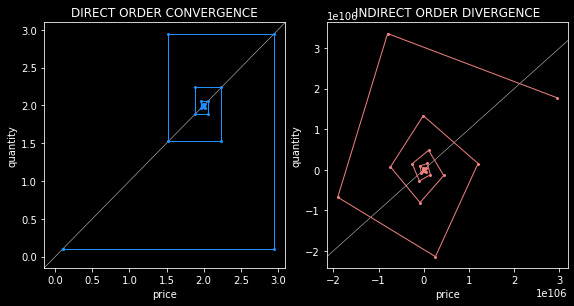

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout()
ax1.axline([0, 0], [1, 1], color = 'gainsboro', linewidth = 0.5)
ax1.plot(historyD['price'], historyD['quantity'], color = 'dodgerblue', marker = 'o', markersize = 2, linewidth = 1)
ax1.title.set_text('DIRECT ORDER CONVERGENCE')
ax1.set_xlabel('price')
ax1.set_ylabel('quantity')

ax2.axline([0, 0], [1, 1], color='gainsboro', linewidth = 0.5)
ax2.plot(historyI['price'], historyI['quantity'], color='lightcoral', marker='o', markersize = 2, linewidth = 1)
ax2.title.set_text('INDIRECT ORDER DIVERGENCE')
ax2.set_xlabel('price')
ax2.set_ylabel('quantity')

### 6. Revisit the non-convergent case. Apply a dampening factor (or overrelaxation paramater) $\lambda$. Consider a grid for $\lambda\in[0.1,0.2,\dots,0.9]$.

In [5]:
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cI, IterI, zI, historyI, historyGammaI = gaussSeidel(0.1, 0.1, 3, 1/2, 1, 1, 'indirect', gammas=gammas)

for gamma in pd.unique(historyGammaI['lambda']):
    print('ORDER: INDIRECT | LAMBDA: {} | Iteration {} | Set (p*, q*) is ({}, {})'.format(
        gamma,
        historyGammaI[historyGammaI['lambda'] == gamma].iloc[-1]['iteration'],
        historyGammaI[historyGammaI['lambda'] == gamma].iloc[-1]['price'],
        historyGammaI[historyGammaI['lambda'] == gamma].iloc[-1]['quantity']))



ORDER: INDIRECT | LAMBDA: 0.1 | Iteration 128.0 | Set (p*, q*) is (1.999986367997711, 2.000010161752128)
ORDER: INDIRECT | LAMBDA: 0.2 | Iteration 78.0 | Set (p*, q*) is (1.9999953932481276, 2.0000061804550766)
ORDER: INDIRECT | LAMBDA: 0.3 | Iteration 66.0 | Set (p*, q*) is (2.000002985098849, 1.9999957435550177)
ORDER: INDIRECT | LAMBDA: 0.4 | Iteration 69.0 | Set (p*, q*) is (1.9999988922040934, 2.0000052524837786)
ORDER: INDIRECT | LAMBDA: 0.5 | Iteration 94.0 | Set (p*, q*) is (1.9999989256158832, 2.000004148160561)
ORDER: INDIRECT | LAMBDA: 0.6 | Iteration 211.0 | Set (p*, q*) is (1.9999979551515525, 1.9999964569951039)
ORDER: INDIRECT | LAMBDA: 0.7 | Iteration 1000.0 | Set (p*, q*) is (-1032961060644454.8, 697578318253874.6)
ORDER: INDIRECT | LAMBDA: 0.8 | Iteration 1000.0 | Set (p*, q*) is (-4.2407416169294714e+60, 2.1529897804255705e+60)
ORDER: INDIRECT | LAMBDA: 0.9 | Iteration 1000.0 | Set (p*, q*) is (2.558969535976884e+106, 1.8933472524380976e+106)


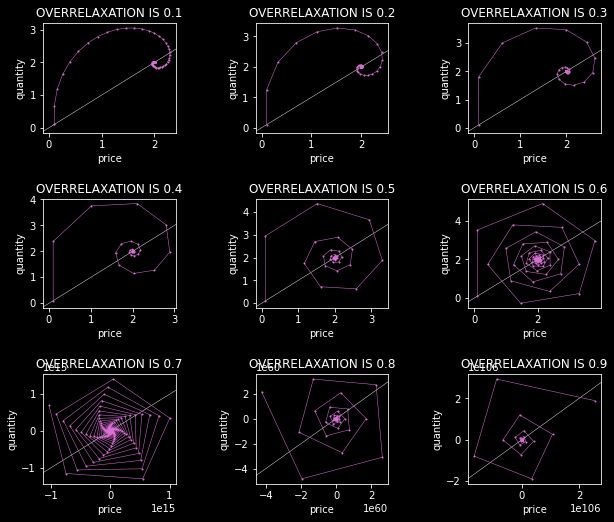

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
fig.subplots_adjust(left = 0.125, right = 0.9, bottom = 0.1, top = 0.9, wspace = 0.6, hspace = 0.6)
axes = axes.ravel()

for i in range(pd.unique(historyGammaI['lambda']).__len__()):
    price = historyGammaI[historyGammaI['lambda'] == gammas[i]]['price']
    quantity = historyGammaI[historyGammaI['lambda'] == gammas[i]]['quantity']

    axes[i].axline([0, 0], [1, 1], color='gainsboro', linewidth = 0.5)
    axes[i].plot(price, quantity, color='orchid', marker='o', markersize = 1, linewidth = 0.5)
    axes[i].title.set_text('OVERRELAXATION IS ' + str(gammas[i]))
    axes[i].set_xlabel('price')
    axes[i].set_ylabel('quantity')

## Exercise 2: Determine the Output Gap

In this problem, you will use OECD data on quarterly GDP for Germany and Greece to determine the output gap of the two countries. The output gap is a measure of how much an economy is running below its capacity (it can also temporarily run above). Formally, the output gap $G_{j,t}$ of country $j$ at time $t$ is defined as the percentage deviation of GDP, $Y_{j,t}$, from its trend $\hat{Y}_{j,t}$:

$$G_{j,t}=\frac{Y_{j,t}-\hat{Y}_{j,t}}{\hat{Y}_{j,t}}$$

A crucial question is how to determine the trend. We will compare two approaches that were discussed in the lecture: OLS and the Hodrick-Prescott (HP) filter.


In [7]:
def applyLog(col):
    return math.log(col)

def outputGap(Y, logY):
    hatY = np.exp(logY)

    return (Y-hatY)/hatY

### 1. Load the quarterly GDP data from $\text{OECD-Germany_Greece_GDP.xls}$. For both countries, calculate log GDP, denoted by $\log Y_{j,t}$.

In [8]:
DataFrame = pd.read_excel('../Helpers/OECD-Germany_Greece_GDP.xls', usecols = 'E:CF')

Timestamp = DataFrame.iloc[3, :]
t = range(1, 81)
Germany = DataFrame.iloc[5, :]
Greece = DataFrame.iloc[6, :]
logGermany = DataFrame.iloc[5, :].map(applyLog)
logGreece = DataFrame.iloc[6, :].map(applyLog)

Y = {
    'Timestamp': Timestamp,
    't': t,
    'Germany': Germany,
    'Greece': Greece,
    'logGermany': logGermany,
    'logGreece': logGreece}

Y = pd.DataFrame(Y).reset_index().drop('index', axis=1)

### 2: Determine the trend of $\log Y_{j,t}$ using the HP filter with $\lambda=1600$, which is a common value for quarterly data.

In [9]:
lam = 1600
cycleGer, trendGer = st.tsa.filters.hpfilter(Y['logGermany'], lam)
cycleGre, trendGre = st.tsa.filters.hpfilter(Y['logGreece'], lam)

### 3: Determine the linear trend of $\log Y_{j,t}$ by OLS regression, i.e. $log Y_{j,t}=\beta_{0,j}+\beta_{1,j}t+\epsilon_{j,t}$

 ### a) Calculate the OLS estimator $\hat{\beta}_j.

 ### b) Calculate the linear trend of log GDP, $\hat{\log Y}_{j,t}=\hat{\beta}_{0,j}+\hat{\beta}_{1,j}t$.

In [15]:
linGer = linreg().fit(
    np.array(Y['t']).reshape(-1, 1), Y['logGermany'])
linGre = linreg().fit(
    np.array(Y['t']).reshape(-1, 1), Y['logGreece'])

print('Germany Regression Coefficients {}, {}'.format(linGer.intercept_, linGer.coef_))
print('Greece Regression Coefficient {}, {}'.format(linGre.intercept_, linGre.coef_))

fitGer = linGer.intercept_ + linGer.coef_ * Y['t']
fitGre = linGre.intercept_ + linGre.coef_ * Y['t']

Germany Regression Coefficients 13.195924446192917, [0.00308756]
Greece Regression Coefficient 10.706494907187011, [0.00313464]


### 4. Calculate the output gap using both HP-trend and the linear trend. Don't forget to transform the log variables back to levels, i.e. $\hat{Y}_{j,t} = \exp(\hat{\log Y}_{j,t})$.

In [110]:
gapGerLin = outputGap(Y['Germany'], fitGer)
gapGerHP = outputGap(Y['Germany'], trendGer)
gapGreLin = outputGap(Y['Greece'], fitGre)
gapGreHP = outputGap(Y['Greece'], trendGre)

### 5. For both Germany and Greece separately, provide the following two plots

 ### a) $\log Y_{j,t}$ together with HP-trend and its linear trend.

 ### b) $G_{j,t}$ for each of the two trends. Show the zero line.

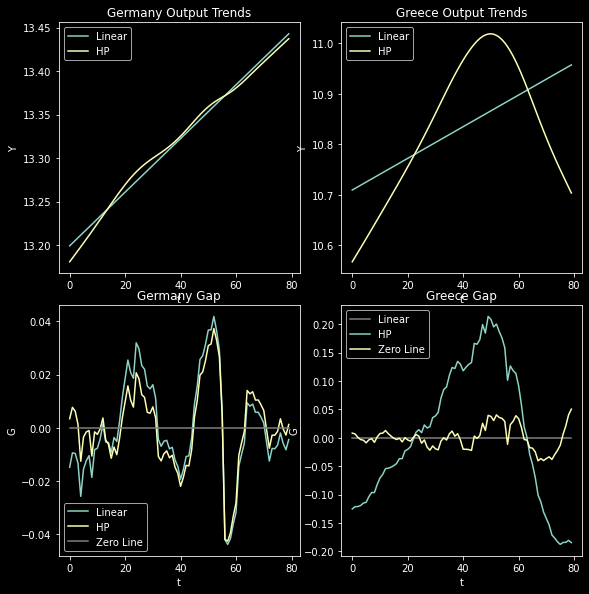

In [115]:
fig, axs = plt.subplots(2,2, figsize=(8, 8))
fig.tight_layout()
axs = axs.ravel()

axs[0].plot(fitGer)
axs[0].plot(trendGer)
axs[0].title.set_text('Germany Output Trends')
axs[0].set_xlabel('t')
axs[0].set_ylabel('Y')
axs[0].legend(['Linear', 'HP'])

axs[1].plot(fitGre)
axs[1].plot(trendGre)
axs[1].title.set_text('Greece Output Trends')
axs[1].set_xlabel('t')
axs[1].set_ylabel('Y')
axs[1].legend(['Linear', 'HP'])

axs[2].plot(np.zeros(len(Y['t'])), color = 'gray')
axs[2].plot(gapGerLin)
axs[2].plot(gapGerHP)
axs[2].title.set_text('Germany Gap')
axs[2].set_xlabel('t')
axs[2].set_ylabel('G')
axs[2].legend(['Zero Line', 'Linear', 'HP'])

axs[3].plot(np.zeros(len(Y['t'])), color = 'gray')
axs[3].plot(gapGreLin)
axs[3].plot(gapGreHP)
axs[3].title.set_text('Greece Gap')
axs[3].set_xlabel('t')
axs[3].set_ylabel('G')
axs[3].legend(['Zero Line', 'Linear', 'HP'])